In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-muted')

from matplotlib import *
from scipy import stats
import seaborn as sns
%matplotlib inline

def set_figure_aesthetics(font_scale_, fig_x, fig_y):
    sns.set(font_scale=font_scale_)
    sns.set_style("whitegrid", {'font.serif': [u'helvetica']})
    plt.figure(figsize=(fig_x, fig_y))

---
Plasmid sequencing results
---
Quality control plots to assess data quality from plasmid sequencing data

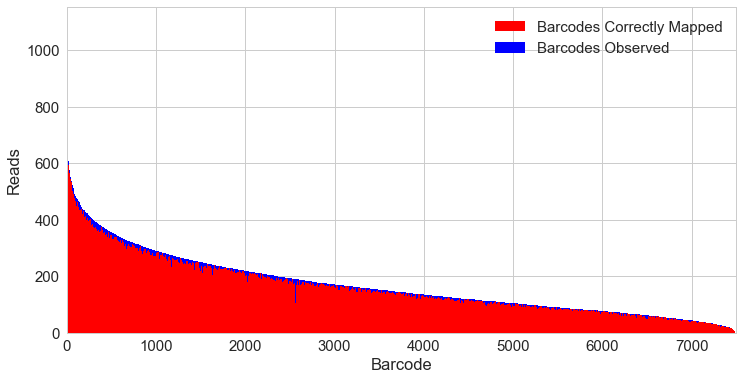

In [2]:
#Plot a histogram of distribution of correct and incorrect barcodes
set_figure_aesthetics(1.5, 12,6)
BC_df = pd.read_csv('BC_correctness_novo_test.tsv', sep = '\t')
BC_df = BC_df.sort_values(by=['total'], ascending = False)

ind = np.arange(7490)
width = 1
p1 = plt.bar(ind, BC_df['correct'], width, color = 'r', edgecolor = "none")
p2 = plt.bar(ind, BC_df['incorrect'], width, color = 'blue', bottom =BC_df['correct'], edgecolor = "none")
plt.ylabel('Reads')
plt.xlabel('Barcode')
plt.legend((p1[0], p2[0]), (('Barcodes Correctly Mapped', 'Barcodes Observed')))
plt.xlim(0,7500)
#plt.savefig('BC_agnostic_map.png')
plt.show()

A histogram of the percentage of correct reads for each barcode
(Figure 2B)

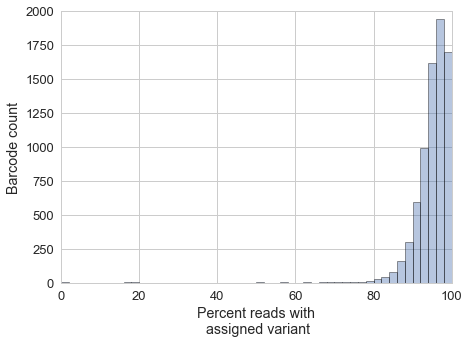

In [3]:
set_figure_aesthetics(1.3, 7,5)
ax = sns.distplot(BC_df['correct_PCT'], kde=False, norm_hist=False, hist_kws=dict(edgecolor="k", linewidth=1))
plt.xlim(0,100);plt.ylim(0,2000)
plt.ylabel("Barcode count"); plt.xlabel("Percent reads with\n assigned variant")
#ax.get_figure().savefig("1o_correct_BC_perecentage_hist.svg",bbox_inches='tight', format = "svg")

Add data from 2o plasmid sequencing data

In [5]:
#merge 2o read info which has read depth for plasmid in final configuration
final_config = pd.read_csv('2o_barcode_reads.tsv', sep = '\t', names = ['variant', 'BC', '2o read count'], skiprows = 1)
BC_df2 = BC_df.merge(final_config, on = 'BC')

Filter out barcodes with high error rate and barcodes not found in final plasmid configuration

In [6]:
#filter out barcodes without 85% of reads with the correct variant
BC_df2['baddies'] = BC_df['correct_PCT'] <85
BC_df2.loc[BC_df2['baddies'] == False, 'baddies'] = "Passed 85% filter"
BC_df2.loc[BC_df2['baddies'] == True, 'baddies'] = "Filtered Out"

#filter out barcodes not found in final configuration
BC_df2.loc[BC_df2['2o read count'] == 0, 'baddies'] = "Filtered Out"

Plot 1o read depth of barcodes filtered out and good barcodes (Supplemental Figure 1)

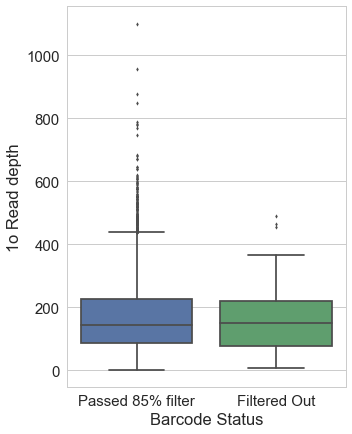

In [7]:
set_figure_aesthetics(1.5, 5,7)
ax = sns.boxplot('baddies', 'total', data = BC_df2, fliersize=3)
plt.ylabel('1o Read depth'); plt.xlabel('Barcode Status')
#ax.get_figure().savefig("1o_BC_filter_depth.png",bbox_inches='tight')

Calculate other important library statistics

In [8]:
#Barcode statistics
baddies = BC_df2[BC_df2['baddies']=="Filtered Out"]
print 'Number of barcodes filtered out: ' + str(len(baddies))
print 'Percentage of barcodes filtered out: ' + str(round(float(len(baddies))/len(BC_df2)*100, 2)) + '%'

#Error rate :(
print 'Barcode misassignment rate: ' + str(round(float(BC_df2['incorrect'].sum())/(BC_df2['correct'].sum()+BC_df2['incorrect'].sum())*100,2)) + '%'

#skew ratio of top 10% vs bottom 10%; a measure for library diversity
#Protocol: Genome-scale CRISPR-Cas9 Knockout and Transcriptional Activation Screening
top_10 = np.percentile(BC_df2[['2o read count']], 90)
bottom_10 = np.percentile(BC_df2[['2o read count']], 10)

print 'Skew ratio: ' + str(top_10/bottom_10)

Number of barcodes filtered out: 136
Percentage of barcodes filtered out: 1.82%
Barcode misassignment rate: 4.59%
Skew ratio: 5.5


---
Splicing Quality Control
---
Read filtering breakdown for each biological sample

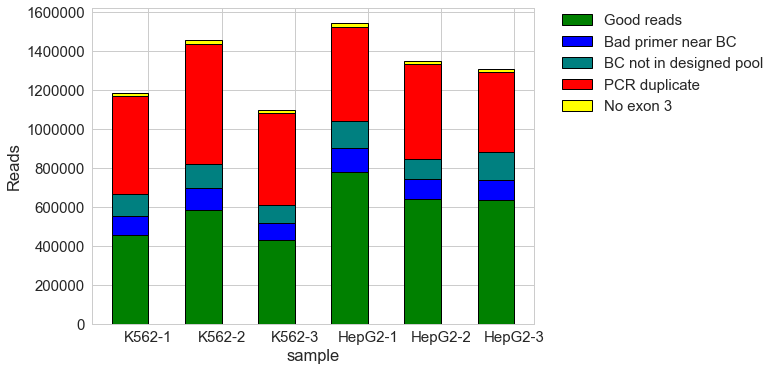

In [9]:
read_dfF = pd.read_csv('Read_filtering_breakdown.tsv', sep='\t')

ind = np.arange(6)
width = 0.5
p1 = plt.bar(ind, read_dfF['good_reads'], width, color = 'green', edgecolor="k", linewidth=1)

#Primer next to barcode sequence isn't correct, implies bad read quality in proximity to barcode
p2 = plt.bar(ind, read_dfF['bad_primer'], width, color = 'blue', bottom = read_dfF['good_reads'], edgecolor="k", linewidth=1)

#Barcode observed is not in the designed pool
p3= plt.bar(ind, read_dfF['BC_foul'], width, color = 'teal', bottom = read_dfF['good_reads'] + read_dfF['bad_primer'], edgecolor="k", linewidth=1)

#Collapsed PCR duplicate reads
p4 = plt.bar(ind, read_dfF['PCR_dup'], width, color = 'red', 
             bottom = read_dfF['good_reads'] + read_dfF['bad_primer']+ read_dfF['BC_foul'], edgecolor="k", linewidth=1)

#Exon 3 is not found in the read (i.e. This plasmid never proceeded into second ligation step and is stuck in 1o configuration)
p5 = plt.bar(ind, read_dfF['no_E3'], width, color = 'yellow',
            bottom = read_dfF['good_reads'] + read_dfF['bad_primer']+ read_dfF['BC_foul'] + read_dfF['PCR_dup'], edgecolor="k", linewidth=1)
plt.ylabel('Reads')
plt.xlabel('sample')
plt.xticks(ind + width/2., ('K562-1', 'K562-2', 'K562-3','HepG2-1', 'HepG2-2', 'HepG2-3'))
plt.legend((p1[0], p2[0],p3[0], p4[0], p5[0]), ('Good reads', 'Bad primer near BC', 'BC not in designed pool',
                                               'PCR duplicate', 'No exon 3'),
           bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.)
plt.tight_layout()
#plt.savefig('read_filtering.png')
plt.show()

Correlations between barcode replicates and biological replicates

In [10]:
#Read in splice read counts by barcode
splice_BC_df = pd.read_csv('splice_results_by_BC.tsv', sep = '\t')

#Filter out bad Barcodes
splice_BC_df = splice_BC_df.merge(BC_df2[['BC', 'baddies']], on = 'BC')
splice_BC_df = splice_BC_df[splice_BC_df['baddies'] == 'Passed 85% filter'].dropna()

#calculate Percent Spliced In (PSI)
def get_PSI(sample, df):
    PSI_df = df.loc[:,(sample + '_in', sample + '_out')]
    PSI= PSI_df[sample + '_in']/ (PSI_df[sample + '_in'] + PSI_df[sample + '_out'])*100
    return PSI

Calculate correlation of PSI between barcode replicates (Figure 3A)

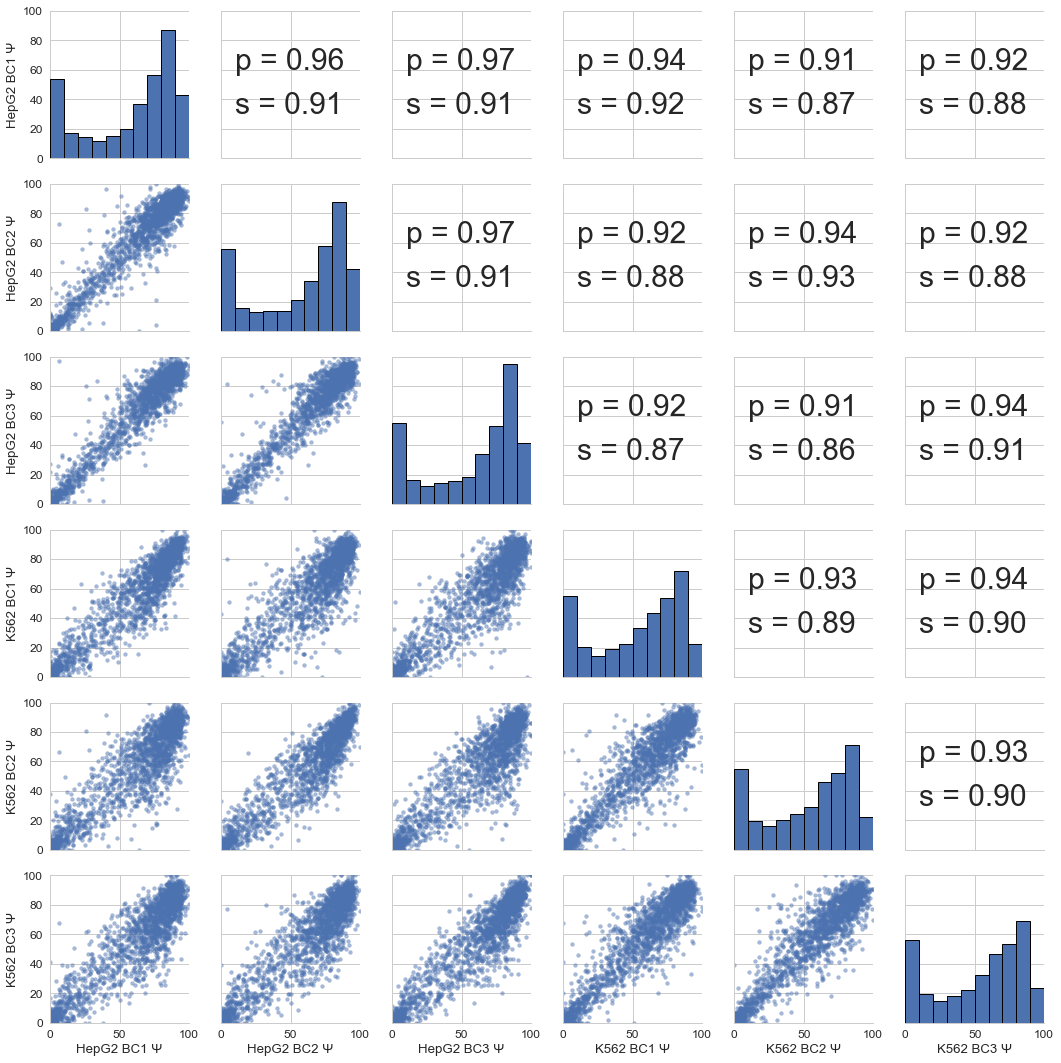

In [11]:
#calculate PSI for each barcode
PSI_BC_df = pd.DataFrame()
PSI_BC_df = splice_BC_df.loc[:,('variant', 'BC')]
for sample in ['H1', 'H2', 'H3', 'K1', 'K2', 'K3']:
    PSI_BC_df[sample] = get_PSI(sample, splice_BC_df)

#Filter out barcodes with no splicing reads
PSI_BC_df = PSI_BC_df.dropna()

#label barcode number for each 
seen_BCs = dict(zip(PSI_BC_df['variant'], [0]*len(PSI_BC_df['BC'])))
BC_number = []
for line in PSI_BC_df.itertuples():
    seen_BCs[line[1]] +=1
    BC_number.append('BC'+ str(seen_BCs[line[1]]))
PSI_BC_df['barcode_number'] = BC_number

#filter out barcode 4 because not all variants have it
PSI_BC_df= PSI_BC_df[PSI_BC_df['barcode_number'] != 'BC4']

#filter out Consensus and Mutated exons
PSI_BC_df = PSI_BC_df[PSI_BC_df['variant'].str.contains("Mutated") == False]
PSI_BC_df = PSI_BC_df[PSI_BC_df['variant'].str.contains("Consensus") == False]

#get average PSI value for each barcode
PSI_BC_df['K_PSI'] = PSI_BC_df[['K1', 'K2', 'K3']].mean(axis=1)
PSI_BC_df['H_PSI'] = PSI_BC_df[['H1', 'H2', 'H3']].mean(axis=1)

#reformat dataframe
PSI_BC_df = pd.pivot_table(PSI_BC_df[['variant','K_PSI', 'H_PSI', 'barcode_number']],
               index='variant', columns='barcode_number').reset_index()
PSI_BC_df = PSI_BC_df['H_PSI'].join(PSI_BC_df['K_PSI'], rsuffix= 'K')
PSI_BC_df.columns = [u"HepG2 BC1 \u03A8", u"HepG2 BC2 \u03A8", u"HepG2 BC3 \u03A8", u"K562 BC1 \u03A8",
                          u"K562 BC2 \u03A8",u"K562 BC3 \u03A8"]

#define spearman and pearson correlation function for graph
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    s, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.annotate("p = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes, size=30)
    ax.annotate("s = {:.2f}".format(s),
                xy=(.1, .3), xycoords=ax.transAxes, size=30)

#plot figure 3A
set_figure_aesthetics(1.2, 10, 10)
ax = sns.PairGrid(PSI_BC_df.dropna())
ax.map_lower(plt.scatter, alpha=0.5, s =15)
ax.map_diag(plt.hist, edgecolor="k", linewidth=1)
ax.map_upper(corrfunc)
ax.set(ylim=(0,100));ax.set(xlim=(0,100))
#ax.savefig("all_sample_PSI_corr_scatter_BC.png")

Calculate correlation of PSI for biological replicates (Figure 3B)

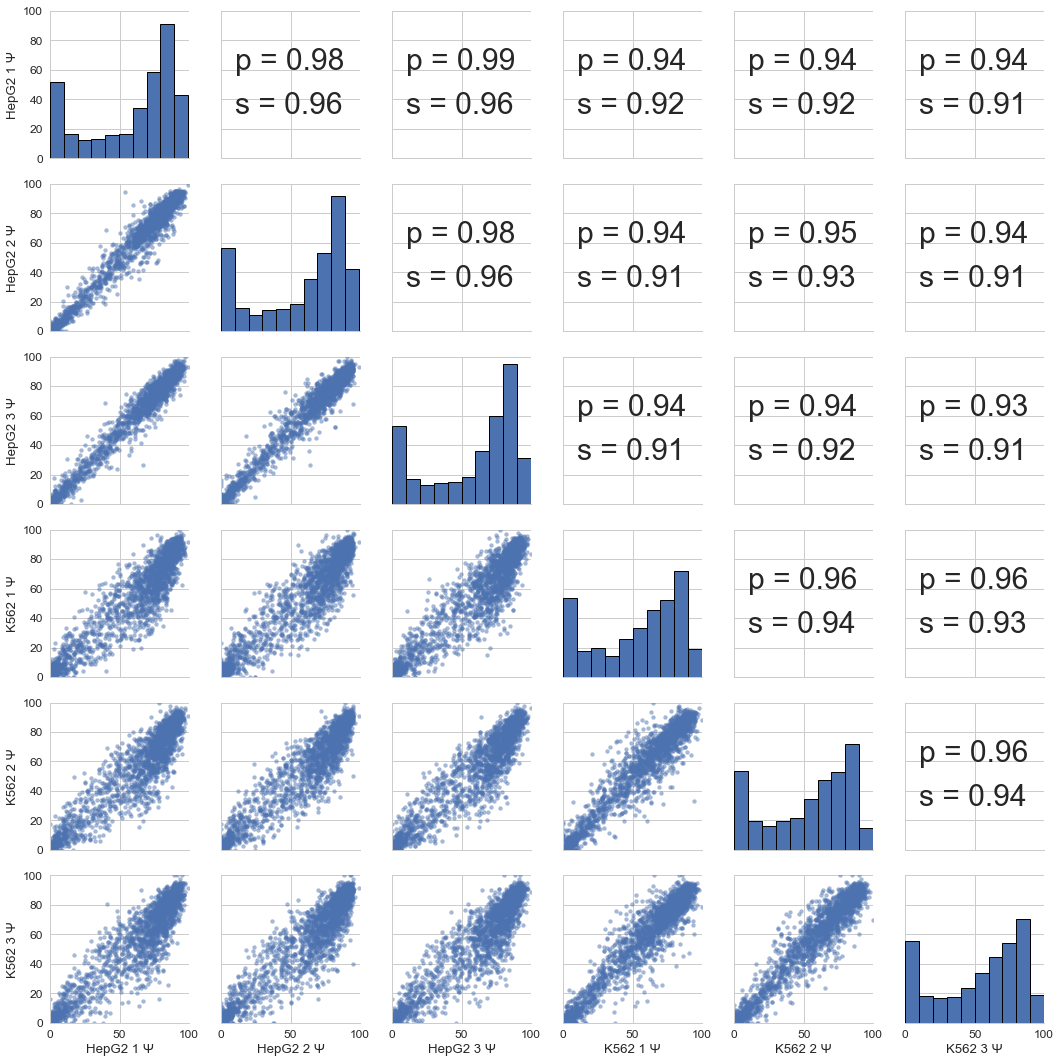

In [12]:
#merge splicing barcode for variants (bad barcodes already filtered out)
bio_corr_df = splice_BC_df.groupby('variant').sum()

#filter out Consensus and Mutated exons; retain reference sequence exons
bio_corr_df = bio_corr_df[bio_corr_df.index.str.contains("Mutated") == False]
bio_corr_df = bio_corr_df[bio_corr_df.index.str.contains("Consensus") == False]

#calculate PSI for each biological sample
for sample in ['H1', 'H2', 'H3', 'K1', 'K2', 'K3']:
    bio_corr_df[sample] = get_PSI(sample, bio_corr_df)

#reformat dataframe
bio_corr_df = bio_corr_df[['H1', 'H2', 'H3', 'K1', 'K2', 'K3']]
bio_corr_df.columns = [u"HepG2 1 \u03A8", u"HepG2 2 \u03A8", u"HepG2 3 \u03A8", u"K562 1 \u03A8",
                          u"K562 2 \u03A8",u"K562 3 \u03A8"]

#plot figure 3B
ax = sns.PairGrid(bio_corr_df.dropna())
ax.map_lower(plt.scatter, alpha = 0.5, s =15)
ax.map_diag(plt.hist, edgecolor="k", linewidth=1)
ax.map_upper(corrfunc)
ax.set(ylim=(0,100));ax.set(xlim=(0,100))
#ax.savefig("all_sample_PSI_corr_scatter.png")

Examine the splicing behavior of exons by exon type (Supplemental Figure 2)

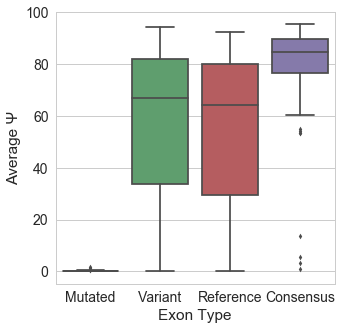

In [14]:
#merge splicing barcode for variants (bad barcodes already filtered out)
exon_cat_df = splice_BC_df.groupby('variant').sum().reset_index()

#calculate PSI for each biological sample
for sample in ['H1', 'H2', 'H3', 'K1', 'K2', 'K3']:
    exon_cat_df[sample] = get_PSI(sample, exon_cat_df)

#classify exons by category
exon_cat_df['class'] = exon_cat_df['variant'].str.split('_').str[3]
new_class = []
for class_ in exon_cat_df['class']:
    if class_ not in ['Mutated', 'Consensus', 'Original']:
        new_class.append('Variant')
    else:
        if class_ != 'Original':
            new_class.append(class_)
        else:
            new_class.append('Reference')
exon_cat_df['class'] = new_class
exon_cat_df['mean_PSI'] = exon_cat_df[['H1', 'H2', 'H3', 'K1', 'K2', 'K3']].mean(axis=1)
exon_cat_df['mean_PSI_K'] = exon_cat_df[['K1', 'K2', 'K3']].mean(axis=1)
exon_cat_df['mean_PSI_H'] = exon_cat_df[['H1', 'H2', 'H3']].mean(axis=1)

#Plot PSI by exon types
exon_cat_df = exon_cat_df.dropna()
set_figure_aesthetics(1.4, 5,5)

order = ['Mutated', 'Variant', 'Reference', 'Consensus']
ax = sns.boxplot(x= 'class', y = 'mean_PSI', data =exon_cat_df, order= order, width = 0.8, fliersize = 4)
plt.ylabel(u"Average \u03A8"); plt.xlabel("Exon Type")
#ax.get_figure().savefig("Control_PSI_boxplots.png",bbox_inches='tight')# ,format = "svg")

---
Similar behavior of variants between HepG2 and K562 cell lines
---
Splicing behavior between K562 and HepG2 cell lines (Figure 4A)

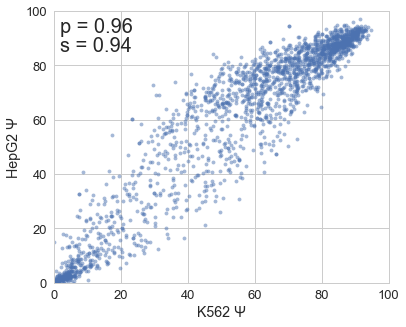

In [19]:
#Plot average splicing behavior for each variant from each cell line
set_figure_aesthetics(1.3,6,5)
ax = sns.regplot(x='mean_PSI_K', y='mean_PSI_H', data = exon_cat_pos, fit_reg=False, scatter_kws={"s": 15, 'alpha':0.5})
plt.ylim(0,100);plt.xlim(0,100); plt.ylabel(u"HepG2 \u03A8");plt.xlabel(u"K562 \u03A8")

#annotate plot with correlation coefficients
x = exon_cat_pos['mean_PSI_K']; y=exon_cat_pos['mean_PSI_H']
r, _ = stats.pearsonr(x, y)
s, _ = stats.spearmanr(x, y)
ax.annotate("p = {:.2f}".format(r), xy=(0.02, 0.92), xycoords=ax.transAxes, size=20)
ax.annotate("s = {:.2f}".format(s), xy=(0.02, 0.85), xycoords=ax.transAxes, size=20)

#plt.savefig("cell_line_PSI_corr.png")

Behavior of delta PSI between K562 and HepG2 cell lines (Figure 4B)

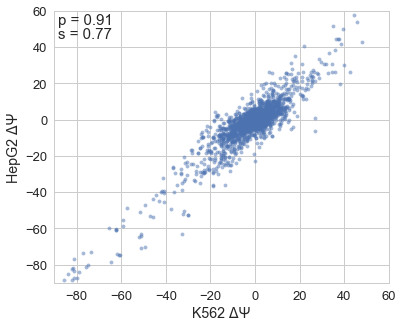

In [20]:
#Plot delta PSI for each cell line
set_figure_aesthetics(1.3,6,5)
ax = sns.regplot(x='delta_psi_K', y='delta_psi_H', data = exon_cat_pos, fit_reg=False, scatter_kws={"s": 15, 'alpha':0.5})

#annotate plot with correlation coefficients
x = exon_cat_pos['delta_psi_K']; y=exon_cat_pos['delta_psi_H']
r, _ = stats.pearsonr(x, y)
s, _ = stats.spearmanr(x, y)
ax.annotate("p = {:.2f}".format(r), xy=(0.01, 0.95), xycoords=ax.transAxes, size=15)
ax.annotate("s = {:.2f}".format(s), xy=(0.01, 0.9), xycoords=ax.transAxes, size=15)

plt.ylim(-90,60);plt.xlim(-90,60); plt.ylabel(u"HepG2 \u0394\u03A8");plt.xlabel(u"K562 \u0394\u03A8")
#plt.savefig("cell_line_delta_PSI_corr.png")

---
Characterize variant changes in splicing (delta PSI)
---

In [16]:
#merge relative splice site position data
relative_splice_pos = pd.read_csv('Vex-seq_results_position_delta.tsv', sep = '\t')
exon_cat_pos = exon_cat_df.merge(relative_splice_pos[['variant', 'donor_position', 'acceptor_position']])

#read in delta PSI dataframe
delta_df = pd.read_csv('delta_psi.tsv', sep = '\t', names= ['variant', 'delta_psi', 'cell_line'])
delta_df_H = delta_df[delta_df['cell_line']=='HepG2']
delta_df_K = delta_df[delta_df['cell_line']=='K562']
delta_df_H.columns = ['variant', 'delta_psi_H', 'cell_line']
delta_df_K.columns = ['variant', 'delta_psi_K', 'cell_line']

#filter out reference, mutated and consensus exons and merge delta PSI dataframe
exon_cat_pos = exon_cat_pos[exon_cat_pos['class']=='Variant']
exon_cat_pos = exon_cat_pos.merge(delta_df_H[['variant', 'delta_psi_H']],
                                  on = 'variant').merge(delta_df_K[['variant', 'delta_psi_K']], on = 'variant')
exon_cat_pos['delta_PSI'] = exon_cat_pos[['delta_psi_H', 'delta_psi_K']].mean(axis=1)
exon_cat_pos['donor_position'] = exon_cat_pos['donor_position'].apply(np.int64)
exon_cat_pos['acceptor_position'] = exon_cat_pos['acceptor_position'].apply(np.int64)

#restrict plotting regions for each side of splice site
dfD = exon_cat_pos[exon_cat_pos["donor_position"] <=20]
dfD = dfD[dfD["donor_position"] >=-33]
dfA = exon_cat_pos[exon_cat_pos["acceptor_position"] <=33]
dfA = dfA[dfA['acceptor_position']>=-50]

Delta PSI of variants proximal to 3' splice site (Figure 5)

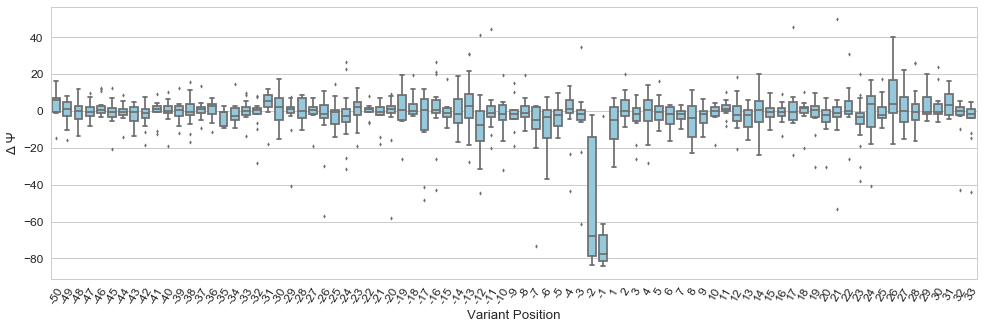

In [17]:
set_figure_aesthetics(1.2, 16.6,5)
plt.xticks(rotation=60)
axA = sns.boxplot(x="acceptor_position", y="delta_PSI", data = dfA, fliersize =3, color = 'skyblue', width = 0.7)
plt.ylabel(u"\u0394 \u03A8")
plt.xlabel("Variant Position")
#plt.savefig("3primeSS_boxplot.png")

Delta PSI of variants proximal to 5' splice site (Figure 5)

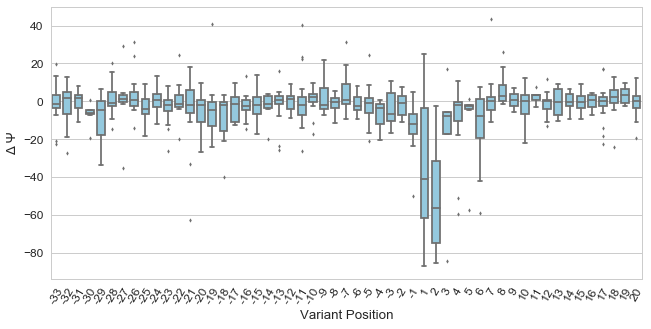

In [18]:
set_figure_aesthetics(1.2, 10.6,5)
plt.xticks(rotation=60)
axD = sns.boxplot(x="donor_position", y="delta_PSI", fliersize =3, data = dfD, color = 'skyblue', width= 0.7)
plt.ylabel(u"\u0394 \u03A8")
plt.xlabel("Variant Position")
#plt.savefig("5primeSS_boxplot.png")

---
Characterization of variants changing splicing
---

Characterization of variants and thier impacts on splicing behavior (Figure 6)

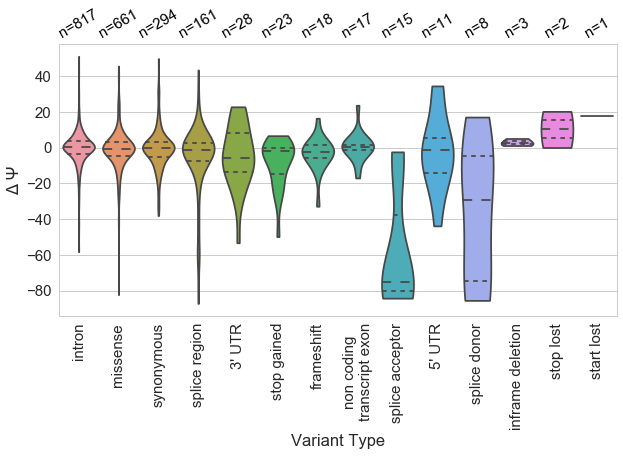

In [21]:
set_figure_aesthetics(1.5, 10,5)

#Average cell line behavior for each cell line
delta_df = pd.read_csv('delta_psi.tsv', sep = '\t', names = ['variant', 'delta_psi', 'cell_line'])
Kdd = delta_df[delta_df['cell_line']=='K562']
Hdd = delta_df[delta_df['cell_line']=='HepG2']
Kdd.columns = ["variant", "K_delta_psi", "cell_line"]
Hdd.columns = ["variant", "H_delta_psi", "cell_line"]
delta_df = Kdd.merge(Hdd, on = "variant")
delta_df = delta_df[['variant', 'K_delta_psi', 'H_delta_psi']]
delta_df['delta_PSI'] = delta_df[['K_delta_psi', 'H_delta_psi']].mean(axis=1)

#read in variant annotation information obtained from Variant Effect Predictor
VEP_df = pd.read_csv('68_97_VEP_multiple.tsv', '\t')
delta_df_2 = delta_df.merge(VEP_df, on = 'variant')

#group data by annotation
dfg = delta_df_2.groupby('annotation')
counts = sorted([len(v) for k, v in dfg], reverse = True)
order = ['intron', 'missense', 'synonymous', 'splice region', "3' UTR", 'stop gained', 'frameshift', 'non coding transcript exon',
           'splice acceptor', "5' UTR", 'splice donor', 'inframe deletion', 'stop lost', 'start lost']
labels = ['intron', 'missense', 'synonymous', 'splice region', "3' UTR", 'stop gained', 'frameshift', 'non coding\ntranscript exon',
           'splice acceptor', "5' UTR", 'splice donor', 'inframe deletion', 'stop lost', 'start lost']

#plot violin plots of delta PSI for each annotation group
ax = sns.violinplot(x= 'annotation', y = 'delta_PSI', data =delta_df_2, cut =0, scale = "width", order = order,
                   inner="quartiles")
plt.ylabel(u"\u0394 \u03A8"); plt.xlabel("Variant Type")
plt.xticks(range(0,14), labels, rotation=90)

#annotate plots with n's for each annotation group
for i in range(0,14):
    plt.text(i, 60, "n="+str(counts[i]), ha='center', va='bottom', color='k', size =15, rotation = 30)
#ax.get_figure().savefig("Annotation_boxplots.png",bbox_inches='tight')#, format = "svg")

Conservation of impactful splicing variants (Figure 7)

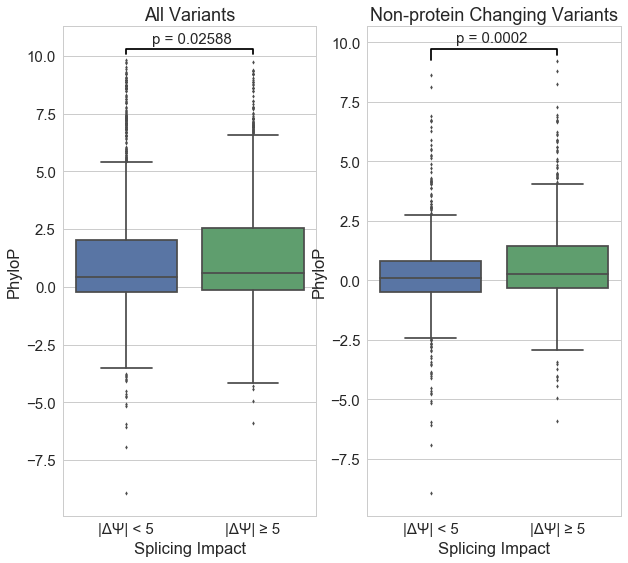

In [22]:
#merge dataframes of delta_PSI, 100-way vertebrae PhyloP, and Variant Effect Predictions
PhyloP = pd.read_csv('68_97_phyloP.tsv', sep = '\t')
PhyloP = PhyloP.merge(delta_df, on = 'variant')
PhyloP = pd.merge(PhyloP, VEP_df, how = 'outer', on =['variant'])

#Identify variants which are predicted to change protein
Protein_changers = ['missense', 'stop gain', 'splice donor', 'splice acceptor', 'start lost', 'frameshift', 'inframe deletion']
PhyloP['Prot_change']=''
PhyloP.loc[PhyloP['annotation'].isin(Protein_changers) == True, 'Prot_change'] = True
PhyloP.loc[PhyloP['annotation'].isin(Protein_changers) == False, 'Prot_change'] =False

#characterize variants as high or low impact
PhyloP['impact']=''
PhyloP.loc[abs(PhyloP['delta_PSI']) >=5, 'impact'] = 'high'
PhyloP.loc[abs(PhyloP['delta_PSI']) < 5, 'impact'] = 'low'

#Mann-Whitney-U test for high vs. low impact
MWU_p_all =  stats.mannwhitneyu(PhyloP[PhyloP['impact'] == 'high']['PhyloP'],
                                PhyloP[PhyloP['impact'] == 'low']['PhyloP'])[1]

#do the same stuff for non-protein changing variants
PhyloP_same_prot = PhyloP[PhyloP['Prot_change']==False]
MWU_p_same_prot =  stats.mannwhitneyu(PhyloP_same_prot[PhyloP_same_prot['impact'] == 'high']['PhyloP'],
                                      PhyloP_same_prot[PhyloP_same_prot['impact'] == 'low']['PhyloP'])[1]

f, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 9))

#plot change bars and p-values
y1 = max(PhyloP['PhyloP'])+0.25; y2 = max(PhyloP['PhyloP'])+0.5
ax1.plot([0,0,1,1], [y1,y2,y2,y1], color = 'black')
ax1.text(0.2, y2+0.25, "p = " + str(round(MWU_p_all, 5)), fontsize=15)
y0 = 9.25; y1 = max(PhyloP_same_prot['PhyloP'])+0.25; y2 = max(PhyloP_same_prot['PhyloP'])+0.5
ax2.plot([0,0,1,1], [y0,y2,y2,y1], color = 'black')
ax2.text(0.2, y2+0.25, "p = " + str(round(MWU_p_same_prot, 5)), fontsize=15)
ax1.set_title('All Variants'); ax2.set_title('Non-protein Changing Variants')

#Plot boxplots for high and low impact variants for all variants and non-protein changing variants
sns.boxplot(x='impact', y = 'PhyloP', data = PhyloP.dropna(), fliersize=3, ax =ax1)
sns.boxplot(x='impact', y = 'PhyloP', data = PhyloP_same_prot.dropna(), fliersize=3, ax =ax2)
for ax in [ax1, ax2]:
    ax.set_xticklabels([u"|\u0394\u03A8| < 5", u"|\u0394\u03A8| \u2265 5"])
    ax.set_xlabel('Splicing Impact')
#plt.savefig("PhyloP_delta_PSI.png",bbox_inches='tight')#, format = "svg")

Analysis of NMD on splicing behavior (Supplemental Figure 3)

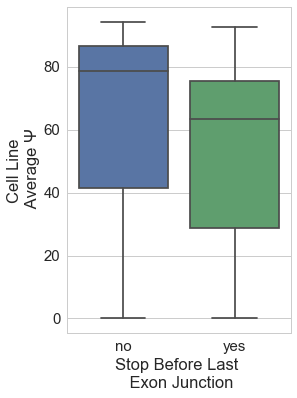

In [23]:
#Read in premature stop codon information in the context of the plasmid, not the genome
PTC_df = pd.read_csv('68_97_premature_stop_codons.tsv', sep = '\t', names = ['variant', 'PTC'])
PTC_df = PTC_df.merge(exon_cat_pos, on ='variant')

#Plot splicing behavior of premature stop codons
set_figure_aesthetics(1.5,4,6)
sns.boxplot(x= 'PTC', y = 'mean_PSI', data =PTC_df, fliersize=3)
plt.ylabel(u"Cell Line\n Average \u03A8")
plt.xlabel("Stop Before Last \n Exon Junction")

#fig.savefig('NMD_effect.png',  bbox_inches='tight')